# Up and Running With Prefect

There are many types of computations that can be broken down into subtasks. Some of these tasks may be resource-intensive or long-running, and may fail at any time for multiple reasons. Being able to define tasks, chain them together, and monitor execution is a nontrivial part of any modern computational pipeline. However, most researchers, data scientists, and software engineers want to focus on solving big-picture questions without worrying about these kinds of bookkeeping details. In the past decade or so, several task management libraries have attempted to make task tracking easy for the programmer, with [Apache Airflow](https://airflow.apache.org/) and [Luigi](https://github.com/spotify/luigi) being some of the most well known. Here, we will focus on a recent addition, [Prefect](https://github.com/prefecthq/prefect).

![Task graph showing](drawing.png)

## Prefect

Prefect is an open source workflow management library designed to make it simple for users to keep track of task execution with only minimal changes to their code. The first public release of prefect, v0.2.0, was in July of 2018, with the Prefect team releasing on a regular cadence ever since. [prefect.io](Prefect), the company behind the Prefect library (also known as [Prefect Core](https://www.prefect.io/core) in the official documentation), offers a cloud-based task management dashboard called [Prefect Cloud](https://www.prefect.io/cloud/) as their flagship product. By itself, the Prefect library is [open source](https://github.com/PrefectHQ/prefect) and totally free to use. Today we'll explore some of `prefect`'s data structures by building a simple pipeline from the ground up. Along the way, we'll show how to

* define the _tasks_ (read: functions) that will make up the pipeline
* chain tasks together into a _flow_ as a way of defining their interdependencies
* run the pipeline, and examine the output
* visualize the task graph with `graphviz`


### Installing prefect

First we'll need to install `prefect`; we'll also need [pandas](https://pandas.pydata.org/) and [numpy](https://numpy.org/). For example data, we'll make use of the [Palmer penguins dataset](hhttps://github.com/mcnakhaee/palmerpenguins):

```bash
pip install prefect prefect[viz] pandas numpy palmerpenguins
```

`prefect[viz]` is an optional extra which is only needed if you want to generate flow visualizations with `graphviz`.


## The Example: How much does it cost to ship all of the Palmer penguins🐧?

The Palmer penguins dataset is a great example dataset first published in 2014 by [Gorman, Williams, and Fraser](https://doi.org/10.1371/journal.pone.0090081) and originally collected into an R package by [Allison Horst](https://allisonhorst.github.io/palmerpenguins/articles/intro.html). Here, we'll use this dataset to calculate the cost of shipping all the penguins on three antarctic islands via the postal service (after all, they can't fly on their own 😢). The penguins need to be classified according to whether they are shippable as-is, or oversize (and therefore subject to a higher fee). Finally, we need to calculate the total cost of shipping the entire bird population. We'll start by importing the required libraries and getting the dataset.

In [1]:
    import prefect, pandas, numpy, palmerpenguins

we'll create a dataframe to train

Describe the data:
* length
* width

In [2]:
    penguins = palmerpenguins.load_penguins()
    penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


### Defining Tasks

With `prefect`, the smallest components of a pipeline are called _tasks_. These are individual operations which are usually strung together to carry out loading of data, transformations, and output. `prefect`'s functional API makes it simple to turn Python functions into `prefect` _tasks_ using decorators. Here we'll define `clean_data`, which removes any rows which contain a `NaN` value. Note that we're only using the return annotations here because Prefect uses them to handle tasks which return multiple arguments:

In [20]:
    @prefect.task
    def clean_data(df) -> pandas.DataFrame:
        return df.dropna()

`split_oversize` splits the penguins into two dataframes: one group of standard sized birds, and another for the oversize population.

In [21]:
    @prefect.task
    def split_oversize(df, oversize_mass = 5000) -> tuple[pandas.DataFrame, pandas.DataFrame]:
        oversize = df['body_mass_g'] < oversize_mass
        return df.loc[~oversize], df.loc[oversize]
    

`compute_costs` computes the shipping cost of a group of penguins based on their mass. Oversize parcels cost $\$0.022 / \mathrm{g}$, while standard parcels cost $\$0.014 / \mathrm{g}$.

In [22]:
    @prefect.task
    def compute_costs(df, is_oversize) -> pandas.DataFrame:
        df = df.copy()
        price_per_g = is_oversize and .022 or .014
        
        df['cost'] = df['body_mass_g']*price_per_g
        return df

`compute_total_cost` adds the cost of shipping the standard as well as the oversize penguins to get the total cost for shipping the entire population.

In [23]:
    @prefect.task
    def compute_total_cost(standard, oversize) -> float:
        return standard['cost'].sum() + oversize['cost'].sum()

### Running the Tasks

Here, we've defined Python functions as usual for removing bad data, for splitting the penguins into dataframes containing standard birds and oversize birds, and for computing the cost of the shipments. The only additional code needed to enable monitoring for these tasks is the `@prefect.task` decorator above each function; this decorator turns each function into a `prefect.Task` class instance. In a moment we'll assemble these tasks into a complete pipeline, but if you still want to execute one of these functions independently of the others, you'll need to call the `.run()` method:

In [24]:
    clean_data.run(penguins)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In order to execute these tasks on our data we'll need to define the order in which they need to be run; we'll do this by chaining them together into a _flow_, which defines their order of execution. 

1. we first need to remove the bad data; some rows have `NaN` values
2. then compute the cost of each shipment, with an additional fee added if it is an oversize penguin
3. finally add the cost of all the shipments together to get the `total_cost` of shipping the entire population

`prefect` allows us to easily define these dependencies with Python's [context manager syntax](https://docs.python.org/3/library/contextlib.html):

In [25]:
    with prefect.Flow('Shipment Flow') as flow:
        penguins_cleaned = clean_data(penguins)
        standard, oversize = split_oversize(penguins_cleaned)
        standard_cost, oversize_cost = compute_costs(standard, is_oversize=False), compute_costs(oversize, is_oversize=True)
        total_cost = compute_total_cost(standard_cost, oversize_cost)

With the flow defined, let's pause for just a moment. In a complicated workflow, there might be _hundreds_ of individual tasks, each of which may have numerous dependencies on the output of other tasks. How can we be sure that the order in which we've instantiated the tasks inside the flow sets up the dependencies as we intended?

One of the most useful features of `prefect` is that it makes it easy to visualize the relationships between the various tasks using `graphviz`:

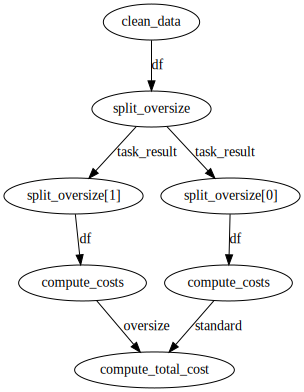

In [26]:
    flow.visualize()

Here, each node of the graph represents a _task_, and each arrow indicates a dependency. Visualizations such as these allow us to quickly confirm that our mental model of the computation matches up with what we intended to program. Brilliant! Okay, the flow has been set up and we're sure the task graph looks good. Let's run it!

In [27]:
    state = flow.run()

[2021-08-12 17:01:07-0700] INFO - prefect.FlowRunner | Beginning Flow run for 'Shipment Flow'
[2021-08-12 17:01:07-0700] INFO - prefect.TaskRunner | Task 'clean_data': Starting task run...
[2021-08-12 17:01:07-0700] INFO - prefect.TaskRunner | Task 'clean_data': Finished task run for task with final state: 'Success'
[2021-08-12 17:01:07-0700] INFO - prefect.TaskRunner | Task 'split_oversize': Starting task run...
[2021-08-12 17:01:07-0700] INFO - prefect.TaskRunner | Task 'split_oversize': Finished task run for task with final state: 'Success'
[2021-08-12 17:01:07-0700] INFO - prefect.TaskRunner | Task 'split_oversize[1]': Starting task run...
[2021-08-12 17:01:07-0700] INFO - prefect.TaskRunner | Task 'split_oversize[1]': Finished task run for task with final state: 'Success'
[2021-08-12 17:01:07-0700] INFO - prefect.TaskRunner | Task 'split_oversize[0]': Starting task run...
[2021-08-12 17:01:07-0700] INFO - prefect.TaskRunner | Task 'split_oversize[0]': Finished task run for task wi

From the information that `prefect` by default logs to stdout, it looks like all tasks executed successfully. Next, let's look at the results.

## Interpreting the results

Prefect has a number of useful features related to storing, caching, and retrieving results. By default, the `State` instance returned by `flow.run()` stores the state of each task in a dictionary:

In [28]:
    task_results = state.result
    task_results

{<Task: clean_data>: <Success: "Task run succeeded.">,
 <Task: split_oversize[1]>: <Success: "Task run succeeded.">,
 <Task: split_oversize[0]>: <Success: "Task run succeeded.">,
 <Task: compute_costs>: <Success: "Task run succeeded.">,
 <Task: compute_costs>: <Success: "Task run succeeded.">,
 <Task: compute_total_cost>: <Success: "Task run succeeded.">,
 <Task: split_oversize>: <Success: "Task run succeeded.">}

The `Result` associated with each `Task` instance contains the output of the decorated function:

In [29]:
    task_results[total_cost].result

27896.1

This is the total cost of shipping the entire population of standard and oversize penguins. Finally, we can visualize the state of the flow, this time after the run:

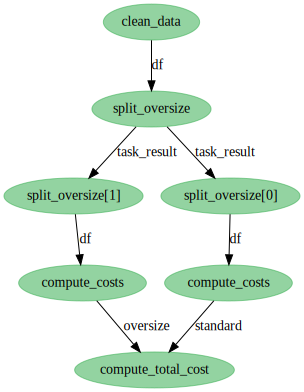

In [30]:
    flow.visualize(flow_state=state)

Each node is now green, indicating that it executed successfully.

## Going further with prefect

We've demonstrated how Prefect can quickly and simply manage and track task execution. Although this isn't the most complicated example, it succinctly illustrates some of the core features of Prefect, and could be readily modified to tackle more difficult problems. While [prefect.io](https://www.prefect.io/) certainly targets machine learning pipelines with its branding and documentation, Prefect could be useful for anything where task tracking is important - including research applications.

If you'd like to learn more about prefect's powerful [caching and data persistence mechanisms](https://docs.prefect.io/core/concepts/persistence.html), [notifications](https://docs.prefect.io/core/concepts/notifications.html#responding-to-state) (including Slack integration!), and other capabilities take a look  at the docs and tutorials available at https://docs.prefect.io/core/.